## Business Understanding
Objective: Predict the unit sales for thousands of items sold at different Favorita stores.

Business Goals:

1. Ensure optimal stock levels at all stores.

2. Improve demand forecasting accuracy.

3. Understand factors affecting sales (promotions, holidays, oil prices, etc.).

Analytical Questions:

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## Data Understanding

Importing Libraries

In [1]:
import pyodbc     
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
from dotenv import load_dotenv
import pandas as pd
import warnings 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer


warnings.filterwarnings('ignore')

Connecting to the database

In [2]:
# Load environment variables from .env file
load_dotenv()
environment_variables=dotenv_values('.env')# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

# Specify port if necessary (default SQL Server port is 1433)
port = 1433
server_with_port = f"{server},{port}"

# Update connection string to use ODBC Driver 17 for SQL Server
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER={dap-projects-database.database.windows.net};"
    "DATABASE={dapDB};"
    "UID={learning_project_3};"
    "PWD={A$uB1Lp3$2@24}"
)

 
try:
    # Establish connection to the database
    conn = pyodbc.connect(connection_string)
    cursor = conn.cursor()

    # Example query to test the connection
    cursor.execute("SELECT TOP 10 * FROM dbo.oil")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

except pyodbc.Error as ex:
    print("OperationalError:")
    print("Arguments:", ex.args)
    print("Connection String:", connection_string)

(datetime.date(2013, 1, 1), None)
(datetime.date(2013, 1, 2), 93.13999938964844)
(datetime.date(2013, 1, 3), 92.97000122070312)
(datetime.date(2013, 1, 4), 93.12000274658203)
(datetime.date(2013, 1, 7), 93.19999694824219)
(datetime.date(2013, 1, 8), 93.20999908447266)
(datetime.date(2013, 1, 9), 93.08000183105469)
(datetime.date(2013, 1, 10), 93.80999755859375)
(datetime.date(2013, 1, 11), 93.5999984741211)
(datetime.date(2013, 1, 14), 94.2699966430664)


In [3]:
#reading the oil table
query = "SELECT * FROM dbo.oil"

oil = pd.read_sql(query, conn)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
#reading the holidays_events table
query = "SELECT * FROM dbo.holidays_events"

holidays_events = pd.read_sql(query, conn)
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
#reading the stores table
query = "SELECT * FROM dbo.stores"

stores = pd.read_sql(query, conn)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
# Loading other datasets
train_data = pd.read_csv(r'C:\Users\magyir\Downloads\store-sales-forecasting\train.csv', parse_dates=['date'])
transactions = pd.read_csv(r"C:\Users\magyir\Downloads\store-sales-forecasting\transactions.csv", parse_dates=['date'])
sample_submission = pd.read_csv(r"C:\Users\magyir\Downloads\sample_submission.csv")
test = pd.read_csv(r"C:\Users\magyir\Downloads\test.csv", parse_dates=['date'])

In [7]:
# Ensuring date columns are in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Merging the train datasets
train_data = train_data.merge(stores, on='store_nbr', how='left')
train_data = train_data.merge(oil, on='date', how='left')
train_data = train_data.merge(transactions, on=['date', 'store_nbr'], how='left')
train_data = train_data.merge(holidays_events, on='date', how='left')



In [8]:
#merge the test dataset


In [9]:
#view first 5 rows for merged data
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [10]:
#view first 5 rows for merged data
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type_x        object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  type_y        object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(9)
memory usage: 396.1+ MB


Data Cleaning

In [12]:
# Identify missing values
missing_values = train_data.isnull().sum()
print("Missing values before cleaning:")
print(missing_values[missing_values > 0])



Missing values before cleaning:
dcoilwtico       955152
transactions     249117
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64


In [13]:
# Handle missing values

# Identify numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
categorical_cols = train_data.select_dtypes(include=[object]).columns

# For numerical, we will use interpolation to fill missing values
train_data[numerical_cols] = train_data[numerical_cols].interpolate(method='linear')

# For categorical, replace missing values with a new category,'Unknown' 
constant_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_data[categorical_cols] = constant_imputer.fit_transform(train_data[categorical_cols])



In [14]:
# Identify missing values after cleaning
missing_values = train_data.isnull().sum()
print("Missing values after cleaning:")
print(missing_values[missing_values > 0])


Missing values after cleaning:
dcoilwtico      1782
transactions     561
dtype: int64


In [15]:
# Handling the rest of the missing values using Mean imputation.
mean_imputer = SimpleImputer(strategy='mean')
train_data[numerical_cols] = mean_imputer.fit_transform(train_data[numerical_cols])

In [16]:
# Identify missing values after cleaning
missing_values = train_data.isnull().sum()
print("Missing values after cleaning:")
print(missing_values[missing_values > 0])

Missing values after cleaning:
Series([], dtype: int64)


## EDA

In [17]:
# Summary Statistics
print("Summary Statistics:")
train_data.describe()



Summary Statistics:


,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3.054348e+06,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2015-04-26 12:11:45.717619200,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.780983e+01,1.677344e+03
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,7.546768e+05,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.632000e+01,1.059000e+03
50%,1.507572e+06,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.329665e+01,1.392000e+03
75%,2.255120e+06,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.576844e+01,2.017000e+03
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03
std,8.662610e+05,NaN,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.567412e+01,9.389467e+02


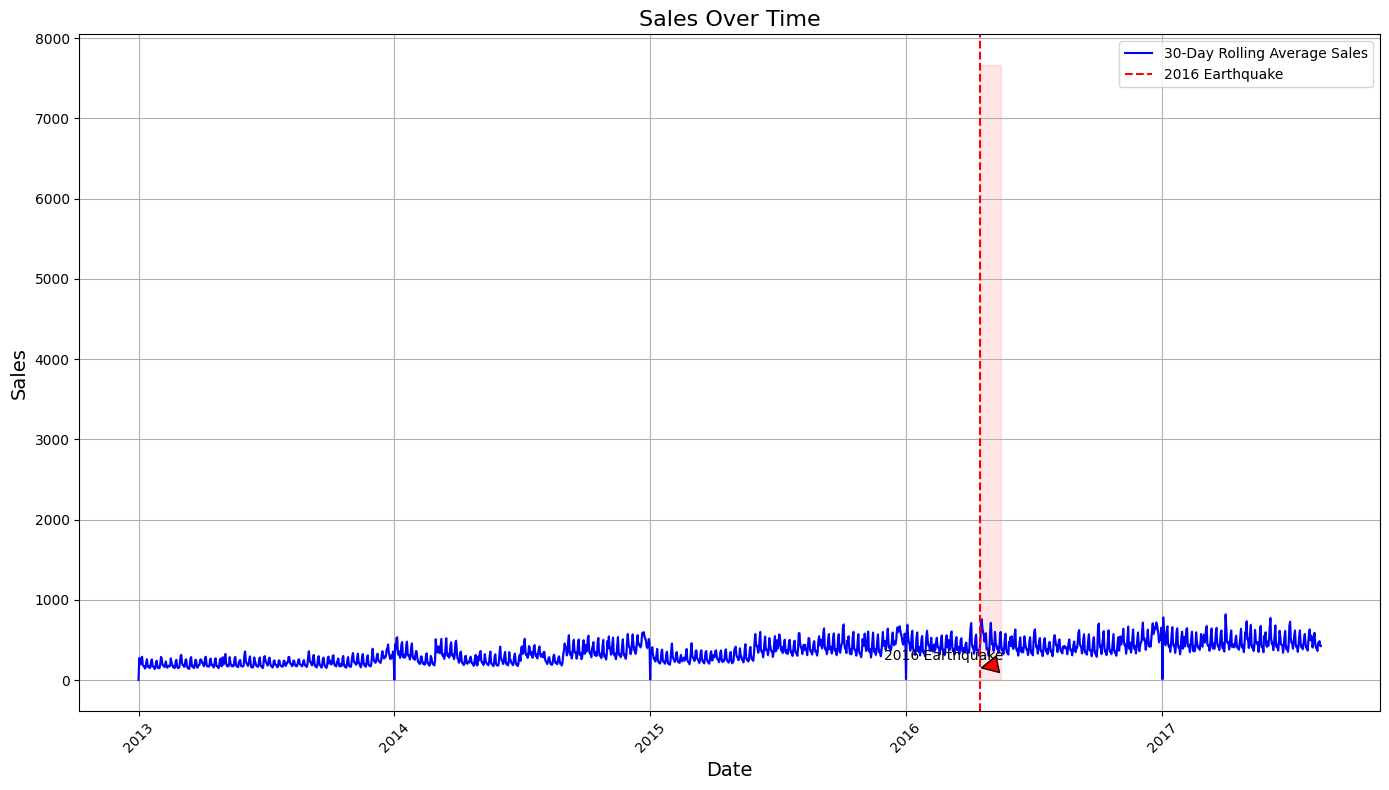

In [18]:
#Sales Over Time

train_data['sales_rolling'] = train_data['sales'].rolling(window=30).mean()

plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='sales_rolling', data=train_data, color='blue', label='30-Day Rolling Average Sales', linewidth=1.5)
plt.title('Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Highlight the earthquake period
plt.axvline(pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='2016 Earthquake')
plt.fill_betweenx(y=[0, max(train_data['sales_rolling'].dropna())], x1=pd.to_datetime('2016-04-16'), x2=pd.to_datetime('2016-05-16'), color='red', alpha=0.1)

# Annotations for specific events
plt.annotate('2016 Earthquake', xy=(pd.to_datetime('2016-04-16'), 150), xytext=(pd.to_datetime('2015-12-01'), 250),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




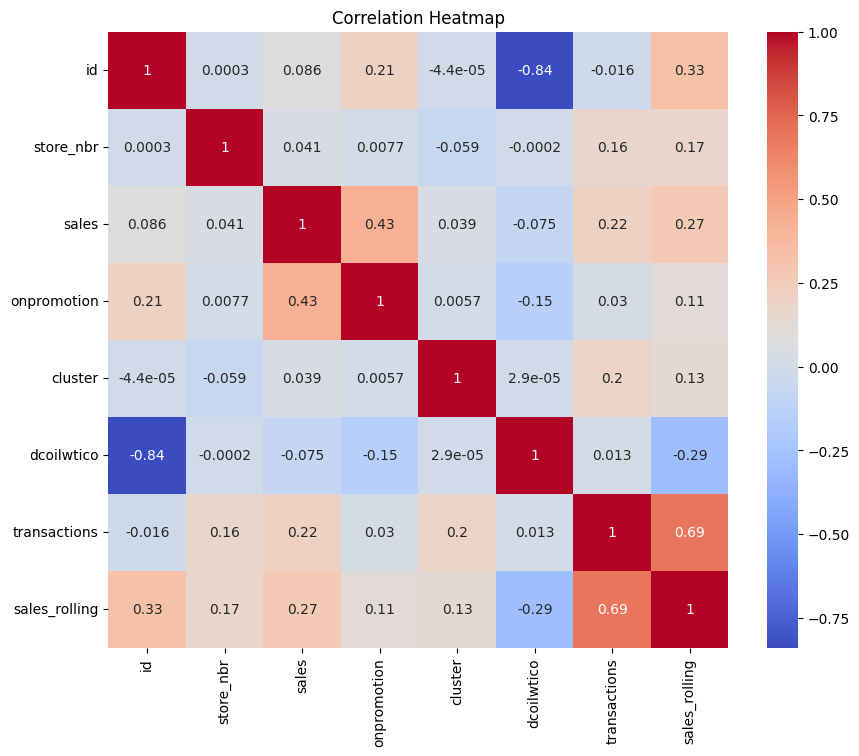

In [19]:
# Correlation Analysis

numeric_cols = train_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



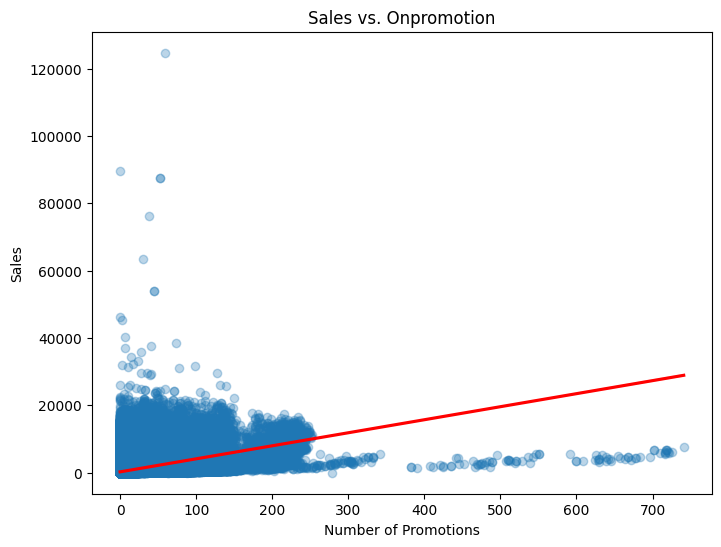

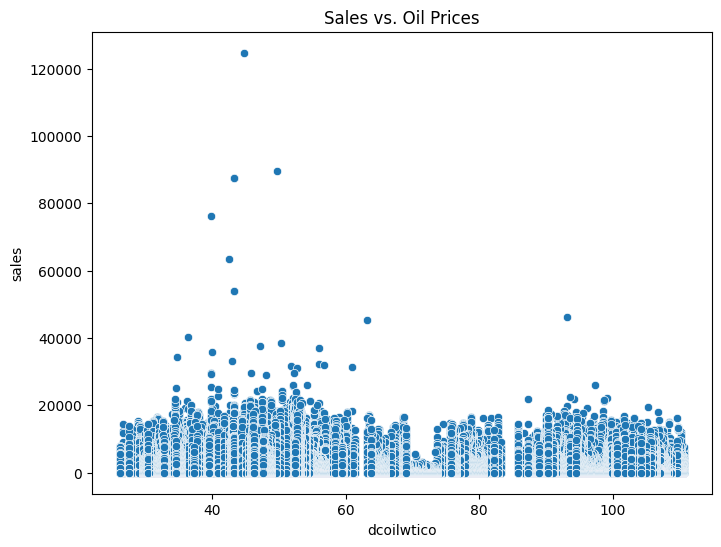

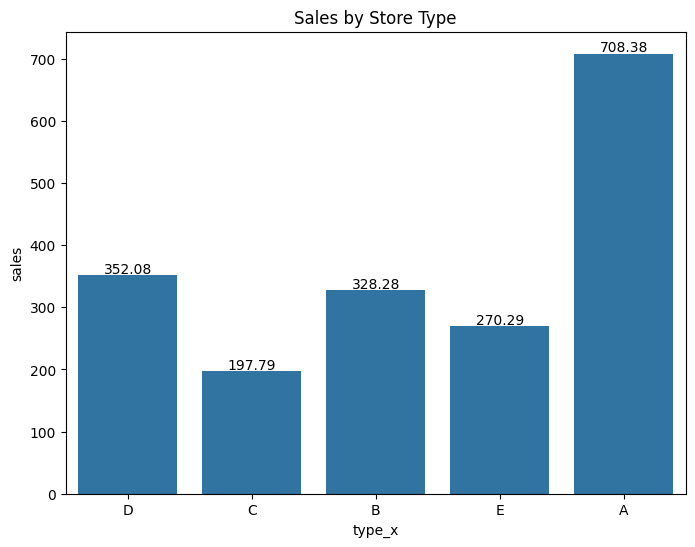

In [25]:

# Sales vs. Promotions
plt.figure(figsize=(8, 6))
sns.regplot(x='onpromotion', y='sales', data=train_data, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Sales vs. Onpromotion')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.show()


# Sales vs. Oil Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_data)
plt.title('Sales vs. Oil Prices')
plt.show()

# Sales by Store Type
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='type_x', y='sales', data=train_data, ci=None)
plt.title('Sales by Store Type')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()




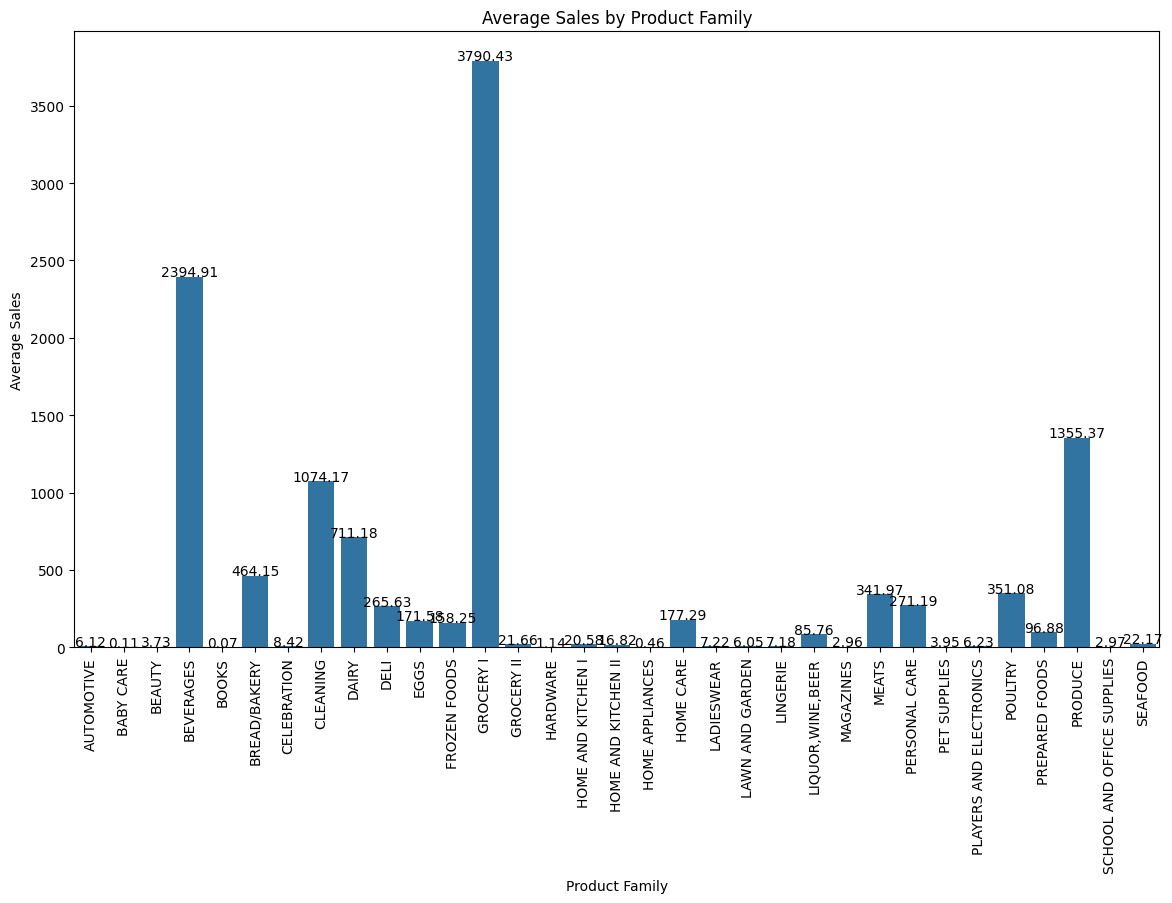

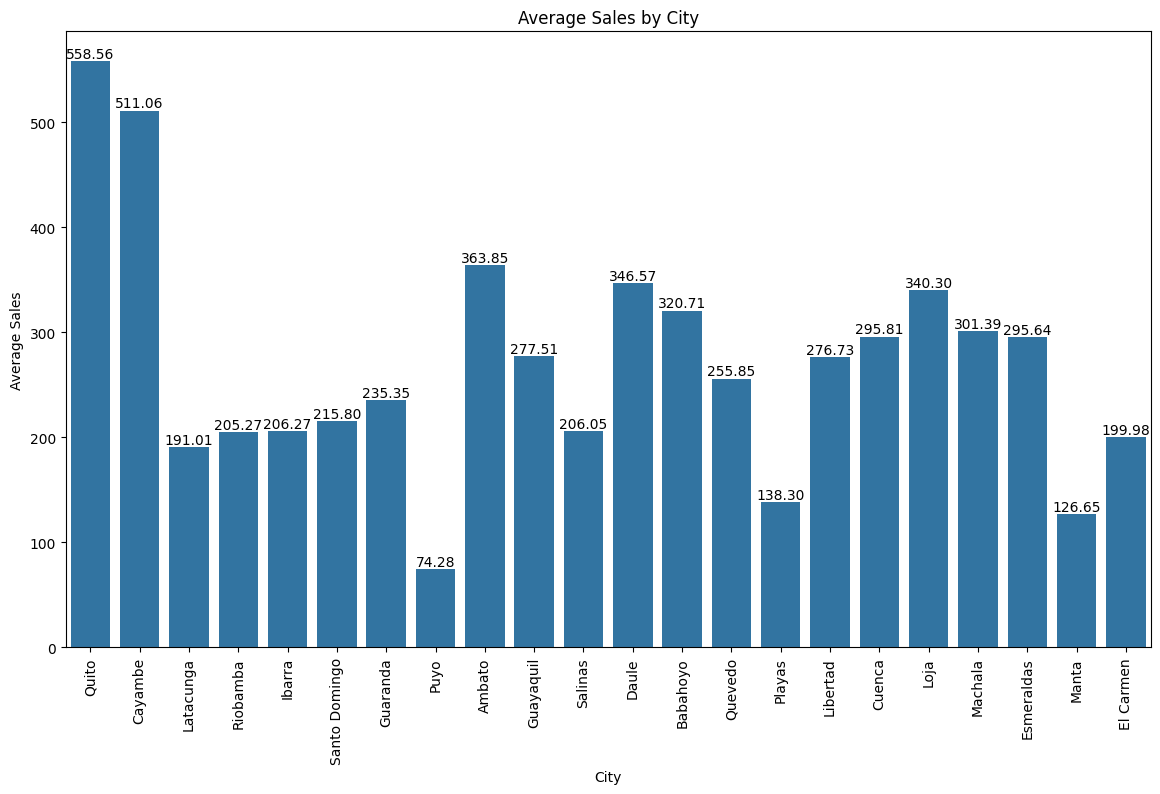

In [21]:
# Sales by product family
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='family', y='sales', data=train_data, estimator=np.mean, ci=None)
plt.title('Average Sales by Product Family')
plt.xticks(rotation=90)
plt.xlabel('Product Family')
plt.ylabel('Average Sales')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()

# Sales by city
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='city', y='sales', data=train_data, estimator=np.mean, ci=None)
plt.title('Average Sales by City')
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Average Sales')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()


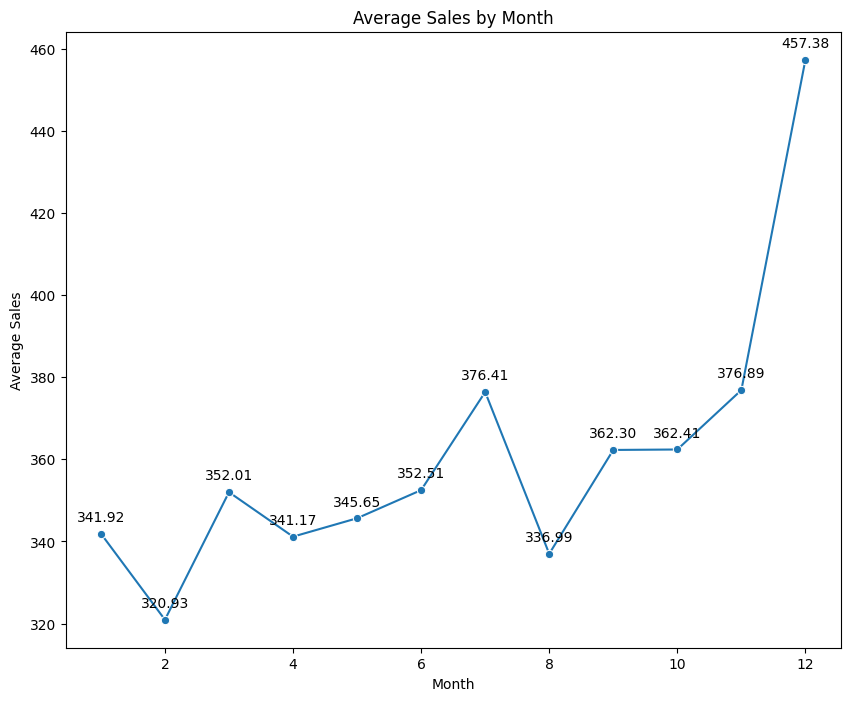

In [22]:
# Sales by Month
train_data['month'] = train_data['date'].dt.month

plt.figure(figsize=(10, 8))
ax = sns.lineplot(x='month', y='sales', data=train_data, estimator=np.mean, ci=None, marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')

# Add data labels
for x, y in zip(range(1, 13), train_data.groupby('month')['sales'].mean()):
    plt.text(x=x, y=y + 3, s=f'{y:.2f}', ha='center')

plt.show()


OBSERVATIONS AND KEY INSIGHTS FROM EDA:

1. Time Series Analysis (Sales Over Time):

Observation:

The line plot shows fluctuations in sales over time with noticeable peaks and troughs.

Insights:

Seasonal Trends: There are clear seasonal patterns where sales peak during certain periods, possibly corresponding to holidays or promotional events.

Growth Patterns: There may be an overall growth or decline trend in sales over the observed period, which could indicate market trends or changes in business performance.

2. Correlation Analysis:

Observation:

The heatmap reveals various levels of correlation between numerical features, such as sales, promotions, and other variables.
Insights:

Strong Positive Correlations: Features like promotions may show a strong positive correlation with sales, suggesting that higher promotional activities tend to boost sales.

Multicollinearity: Some features may be highly correlated with each other, indicating potential multicollinearity issues which need to be considered during modeling to avoid redundant information.

3. Sales vs. Promotions Scatter Plot:
Observation:

The scatter plot displays the relationship between sales and promotions with a visible trend.

Insights:
Positive Relationship: There is a positive relationship between promotions and sales, indicating that increased promotions generally lead to higher sales.

Effectiveness of Promotions: The plot can help determine the extent of impact promotions have on sales, allowing for optimization of promotional strategies.

4. Sales by Product Family:

Observation:

The box plot shows the distribution of sales across different product families with varying median sales and outliers.

Insights:

Top Performers: Some product families consistently have higher median sales, indicating their popularity and strong performance.

Sales Variability: Significant variability within product families suggests different performance levels for different products within the same family, which can inform targeted marketing and inventory decisions.

Outliers: Presence of outliers may indicate special events or promotions that led to exceptionally high sales on certain days.


## Answers to the Analytical Questions

1. Is the train dataset complete (has all the required dates)?

In [26]:
# Check the date range in the dataset
date_range = pd.date_range(start=train_data['date'].min(), end=train_data['date'].max())
missing_dates = date_range.difference(train_data['date'])
print(f"Missing dates: {missing_dates}")


Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


The output for question 1 indicates that the dates missing in the dataset are all Christmas days from 2013 to 2016 (December 25). 

This suggests that the stores might have been closed on Christmas Day each year, which is why there are no sales data for those dates.


The missing dates correspond to Christmas Day, likely indicating that stores were closed, hence no sales data.
This is a valid and expected gap in the data.

2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [31]:
# Ensure the 'year' column exists
train_data['year'] = train_data['date'].dt.year

# Find the lowest and highest sales dates for each year
lowest_sales_indices = train_data.groupby('year')['sales'].idxmin()
highest_sales_indices = train_data.groupby('year')['sales'].idxmax()

# Extract the corresponding rows and include the year
lowest_sales = train_data.loc[lowest_sales_indices, ['year', 'date', 'sales']].reset_index(drop=True)
highest_sales = train_data.loc[highest_sales_indices, ['year', 'date', 'sales']].reset_index(drop=True)

# Combine the results into a single DataFrame
sales_extremes = pd.DataFrame({
    'Year': lowest_sales['year'],
    'Lowest Sales Date': lowest_sales['date'],
    'Lowest Sales': lowest_sales['sales'],
    'Highest Sales Date': highest_sales['date'],
    'Highest Sales': highest_sales['sales']
})

# Display the results
sales_extremes



,Year,Lowest Sales Date,Lowest Sales,Highest Sales Date,Highest Sales
0,2013,2013-01-01,0.0,2013-11-12,46271.000
1,2014,2014-01-01,0.0,2014-12-08,45361.000
2,2015,2015-01-01,0.0,2015-12-14,40351.460
3,2016,2016-01-01,0.0,2016-05-02,124717.000
4,2017,2017-01-01,0.0,2017-04-02,38422.625


3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [34]:
import calendar

# Group by year and month and calculate total sales
monthly_sales = train_data.groupby(['year', 'month'])['sales'].sum().reset_index()
max_monthly_sales = monthly_sales.loc[monthly_sales['sales'].idxmax()]

# Extract year and month for readability
year = int(max_monthly_sales['year'])
month = int(max_monthly_sales['month'])
sales = max_monthly_sales['sales']
month_name = calendar.month_name[month]

# Print the results
print(f"The month with the highest sales is {month_name} {year} with total sales of {sales:.2f}.")


The month with the highest sales is December 2016 with total sales of 30776136.97.


4. Did the earthquake impact sales?

In [36]:
# Analyze sales before and after the earthquake
pre_earthquake = train_data[train_data['date'] < '2016-04-16']
post_earthquake = train_data[train_data['date'] >= '2016-04-16']
pre_earthquake_sales = pre_earthquake.groupby(pre_earthquake['date'].dt.date)['sales'].sum().mean()
post_earthquake_sales = post_earthquake.groupby(post_earthquake['date'].dt.date)['sales'].sum().mean()
print(f"Average sales before earthquake: {pre_earthquake_sales}")
print(f"Average sales after earthquake: {post_earthquake_sales}")


Average sales before earthquake: 567909.8158334461
Average sales after earthquake: 856417.2527526371


There is a significant increase in average sales after the earthquake compared to before the earthquake.
The increase is about 50.7% 

Possible Reasons for the Increase:

i. Relief Efforts: After a natural disaster, there is often an increase in the purchase of essential goods such as food, water, and medical supplies as part of relief efforts.

ii. Rebuilding Activities: The demand for various products might increase due to rebuilding and recovery activities.

iii. Government and NGO Assistance: Assistance from government and non-governmental organizations might lead to increased purchasing power and consumption.

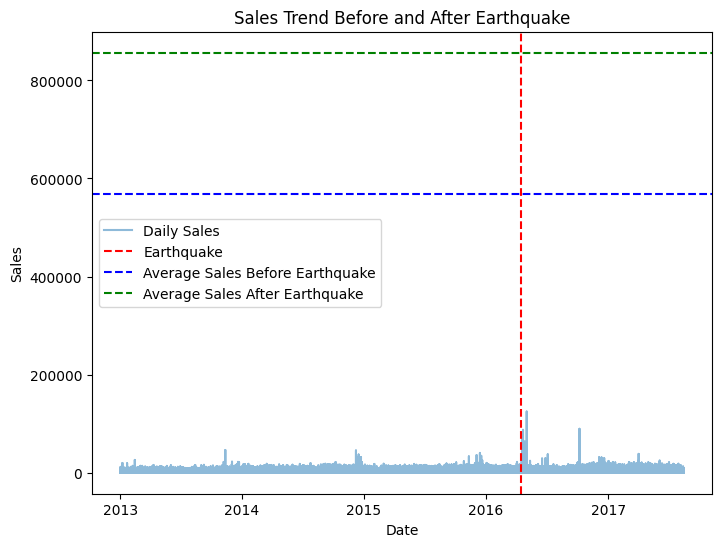

In [38]:

# Plot sales before and after the earthquake
plt.figure(figsize=(8, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
plt.plot(train_data['date'], train_data['sales'], label='Daily Sales', alpha=0.5)
plt.axvline(pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.axhline(pre_earthquake_sales, color='blue', linestyle='--', label='Average Sales Before Earthquake')
plt.axhline(post_earthquake_sales, color='green', linestyle='--', label='Average Sales After Earthquake')
plt.title('Sales Trend Before and After Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


From the graph above, there is a noticeable increase in average sales after the earthquake compared to before the earthquake, as indicated by the higher green dashed line compared to the blue dashed line.
This significant increase suggests that the earthquake had a substantial impact on sales, likely due to increased demand for essential goods and rebuilding supplies.

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [40]:
# Group by cluster, city, state, and type and calculate average sales
store_group_sales = train_data.groupby(['cluster', 'city', 'state', 'type_x'])['sales'].mean().reset_index()
store_group_sales


,cluster,city,state,type_x,sales
0,1.0,Daule,Guayas,D,346.571239
1,1.0,Guayaquil,Guayas,D,428.446546
2,1.0,Salinas,Santa Elena,D,206.050640
3,2.0,Cuenca,Azuay,D,261.025731
4,3.0,El Carmen,Manabi,C,199.981717
5,3.0,Guayaquil,Guayas,C,120.294687
6,3.0,Machala,El Oro,C,331.657375
7,3.0,Playas,Guayas,C,138.302551
8,3.0,Quevedo,Los Rios,C,255.849898
9,3.0,Santo Domingo,Santo Domingo de los Tsachilas,C,198.104822


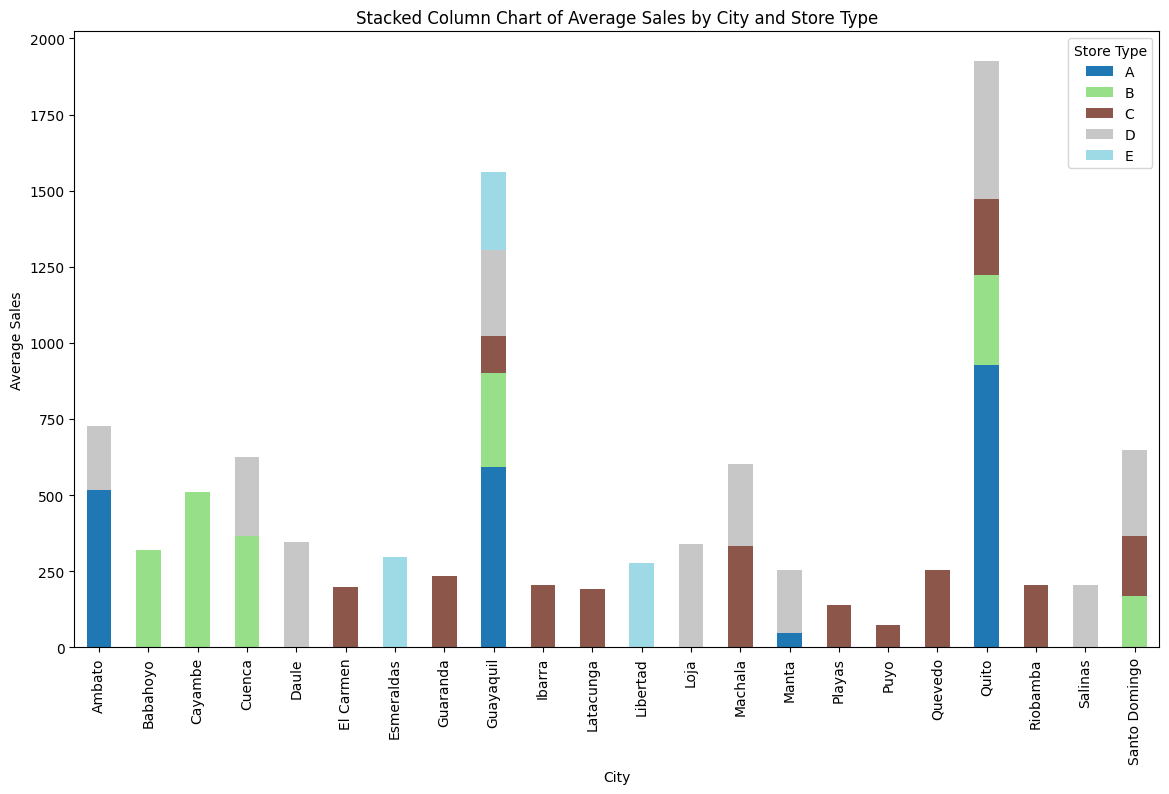

In [42]:
# Aggregate the data to ensure each combination of city and type_x is unique
aggregated_data = store_group_sales.groupby(['city', 'type_x']).agg({'sales': 'mean'}).reset_index()

# Pivot the data for the stacked column chart
pivot_data = aggregated_data.pivot(index='city', columns='type_x', values='sales').fillna(0)

# Plot the stacked column chart
pivot_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Stacked Column Chart of Average Sales by City and Store Type')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.legend(title='Store Type')
plt.show()


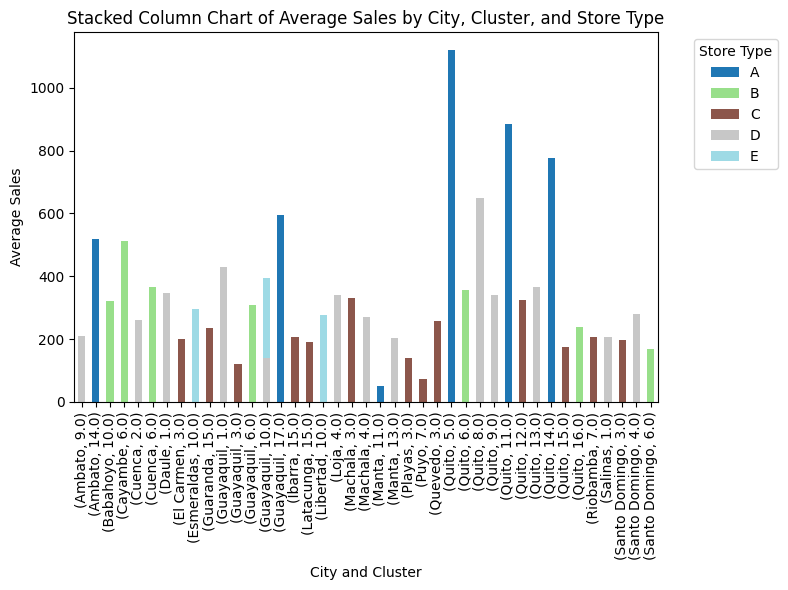

In [45]:

# Aggregate the data to ensure each combination of city, cluster, and type_x is unique
aggregated_data = store_group_sales.groupby(['city', 'cluster', 'type_x']).agg({'sales': 'mean'}).reset_index()

# Pivot the data for the stacked column chart
pivot_data = aggregated_data.pivot_table(index=['city', 'cluster'], columns='type_x', values='sales', aggfunc='mean').fillna(0)

# Plot the stacked column chart
pivot_data.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20')
plt.title('Stacked Column Chart of Average Sales by City, Cluster, and Store Type')
plt.xlabel('City and Cluster')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Key Insights:

i. Quito and Guayaquil are standout cities with consistently high average sales, particularly for Type A stores.

ii. Store Type A is the most successful store type, followed by Type B.

iii. Cluster Analysis reveals that certain clusters, such as 5.0 and 11.0, contain high-performing stores, which might be strategically important locations or well-managed stores.

6. Are sales affected by promotions, oil prices, and holidays?

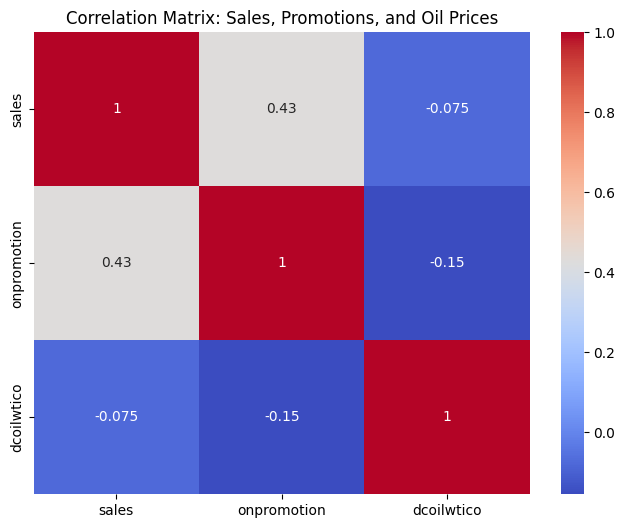

In [51]:
# Visualize correlation matrix between sales, promotions, and oil prices.
corr_matrix = train_data[['sales', 'onpromotion', 'dcoilwtico']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Sales, Promotions, and Oil Prices')
plt.show()


Summary of key insights:

Promotions have a moderate positive impact on sales. Increasing the number of promotions is likely to result in higher sales.

Oil Prices have a minimal impact on sales, indicating that sales are relatively insensitive to changes in oil prices.

Promotions and Oil Prices have a weak negative relationship, suggesting that other factors are more critical in determining the number of promotions.

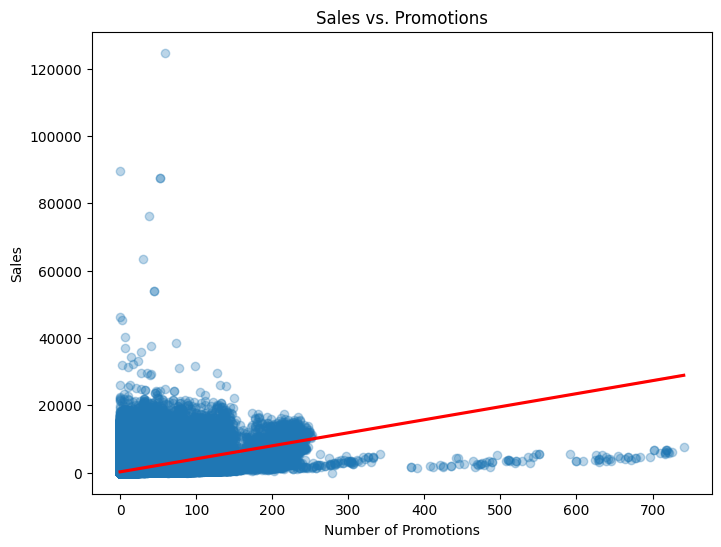

In [57]:
# Visualize the relationship between sales and promotion with a red regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='onpromotion', y='sales', data=train_data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Sales vs. Promotions')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.show()






Summary of Key Insight:

i. The regression line suggests that promotions do positively impact sales, but the effect is relatively modest.

ii. There are notable outliers with very high sales and low promotion counts, suggesting that some products or periods have exceptionally high demand regardless of the number of promotions.

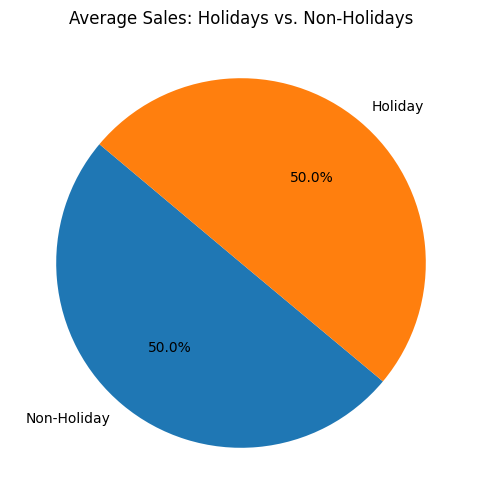

In [59]:
# Create a column to indicate whether the date is a holiday
train_data['is_holiday'] = train_data['type_y'].apply(lambda x: 1 if x == 'Holiday' else 0)

# Group by 'is_holiday' to find average sales
holiday_sales = train_data.groupby('is_holiday')['sales'].mean().reset_index()

# Map 0 and 1 to 'Non-Holiday' and 'Holiday'
holiday_sales['is_holiday'] = holiday_sales['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(holiday_sales['sales'], labels=holiday_sales['is_holiday'], autopct='%1.1f%%', startangle=140)
plt.title('Average Sales: Holidays vs. Non-Holidays')
plt.show()



The chart shows that the average sales on holidays and non-holidays are represented equally, each accounting for 50% of the total.

This suggests that, on average, there is no significant difference between sales on holidays and non-holidays.


7. What analysis can we get from the date and its extractable features?

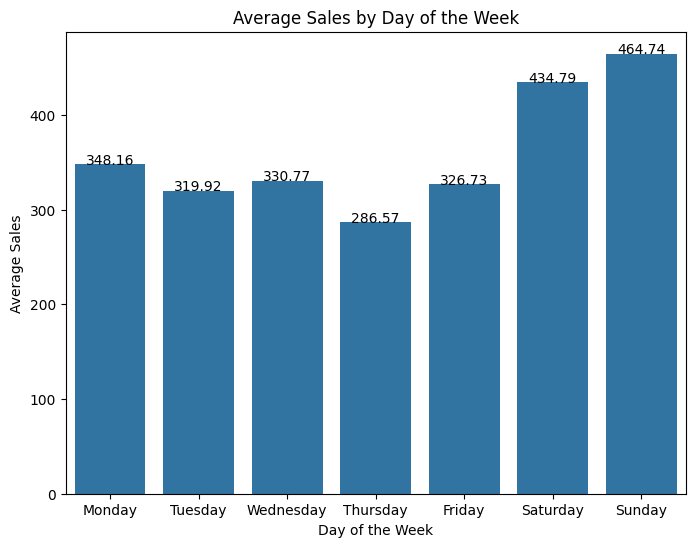

In [72]:
# Create the 'dayofweek' column
train_data['dayofweek'] = train_data['date'].dt.dayofweek

# Analyze sales by day of the week
day_of_week_sales = train_data.groupby('dayofweek')['sales'].mean().reset_index()

# Map numerical day of the week to names
day_of_week_sales['dayofweek'] = day_of_week_sales['dayofweek'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Plot the data
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='dayofweek', y='sales', data=day_of_week_sales, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')

# Add data labels
for index, row in day_of_week_sales.iterrows():
    bar_plot.text(row.name, row.sales, round(row.sales, 2), color='black', ha="center")

plt.show()


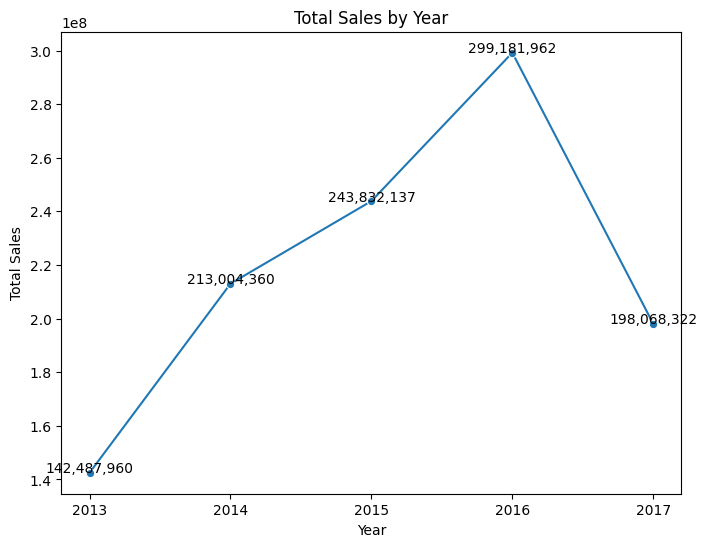

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Extract year from the date
train_data['year'] = train_data['date'].dt.year

# Group by year and calculate total sales
year_sales = train_data.groupby('year')['sales'].sum().reset_index()

# Convert the year column to integer
year_sales['year'] = year_sales['year'].astype(int)

# Plot the data
plt.figure(figsize=(8, 6))
line_plot = sns.lineplot(x='year', y='sales', data=year_sales, marker='o')
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(year_sales['year'])

# Add data labels
for index, row in year_sales.iterrows():
    line_plot.text(row.year, row.sales, f'{int(row.sales):,}', color='black', ha="center")

plt.show()


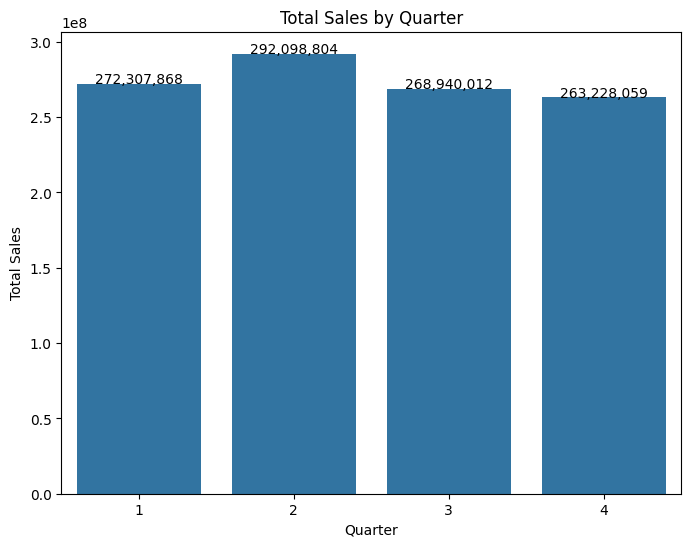

In [75]:
# Ensure the 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Extract quarter from the date
train_data['quarter'] = train_data['date'].dt.quarter

# Group by quarter and calculate total sales
quarter_sales = train_data.groupby('quarter')['sales'].sum().reset_index()

# Plot the data
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='quarter', y='sales', data=quarter_sales)
plt.title('Total Sales by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')

# Add data labels
for index, row in quarter_sales.iterrows():
    bar_plot.text(row.quarter - 1, row.sales, f'{int(row.sales):,}', color='black', ha="center")

plt.show()



In [78]:

import plotly.express as px

# Ensure the 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Extract day from the date
train_data['day'] = train_data['date'].dt.day

# Group by day and calculate total sales
day_sales = train_data.groupby('day')['sales'].sum().reset_index()

# Create the line plot with Plotly
fig = px.line(day_sales, x='day', y='sales', markers=True, title='Total Sales by Day of the Month',
              labels={'day': 'Day of the Month', 'sales': 'Total Sales'})

# Customize tooltips
fig.update_traces(hovertemplate='Day: %{x}<br>Sales: %{y:,}')

# Show the plot
fig.show()


In [79]:

# Ensure the 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Extract week from the date
train_data['week'] = train_data['date'].dt.isocalendar().week

# Group by week and calculate total sales
week_sales = train_data.groupby('week')['sales'].sum().reset_index()

# Create the line plot with Plotly
fig = px.line(week_sales, x='week', y='sales', markers=True, title='Total Sales by Week of the Year',
              labels={'week': 'Week of the Year', 'sales': 'Total Sales'})

# Customize tooltips
fig.update_traces(hovertemplate='Week: %{x}<br>Sales: %{y:,}')

# Show the plot
fig.show()
